In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Load the dataset
data = pd.read_csv('./data/ebay_data.csv')
print("First five rows of the dataset:")
print(data.head())

# Check for missing values
print("\nMissing values in each column:")
print(data.isnull().sum())

# Convert the 'timestamp' column to a datetime object
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Create new time-based features: hour of day and day of week
data['hour'] = data['timestamp'].dt.hour
data['day_of_week'] = data['timestamp'].dt.dayofweek

# Display the updated DataFrame structure
print("\nData types after conversion:")
print(data.dtypes)

First five rows of the dataset:
   session_id  user_id            timestamp       action   price  \
0           1      103  2022-11-01 10:00:41  add_to_cart  187.89   
1           2      271  2022-10-13 18:14:41        click   27.43   
2           3      107  2022-05-24 22:39:31         view  178.22   
3           4       72  2022-01-19 18:11:21        click  465.00   
4           5      189  2022-01-18 19:02:56         view  192.72   

  product_category  purchase  
0          Fashion         0  
1             Toys         0  
2             Toys         0  
3      Electronics         0  
4          Fashion         0  

Missing values in each column:
session_id          0
user_id             0
timestamp           0
action              0
price               0
product_category    0
purchase            0
dtype: int64

Data types after conversion:
session_id                   int64
user_id                      int64
timestamp           datetime64[ns]
action                      object
pric


Summary statistics:
        session_id      user_id                      timestamp        price  \
count  1000.000000  1000.000000                           1000  1000.000000   
mean    500.500000   150.724000  2022-07-03 03:22:03.222000128   252.041530   
min       1.000000     1.000000            2022-01-01 02:39:47     5.090000   
25%     250.750000    79.500000     2022-03-30 11:48:06.500000   130.120000   
50%     500.500000   150.500000     2022-07-02 05:32:31.500000   254.635000   
75%     750.250000   224.250000  2022-10-09 02:24:41.249999872   377.335000   
max    1000.000000   300.000000            2022-12-31 23:57:49   498.820000   
std     288.819436    85.444488                            NaN   142.403227   

         purchase         hour  day_of_week  
count  1000.00000  1000.000000  1000.000000  
mean      0.19300    11.143000     2.953000  
min       0.00000     0.000000     0.000000  
25%       0.00000     5.000000     1.000000  
50%       0.00000    11.000000     3.

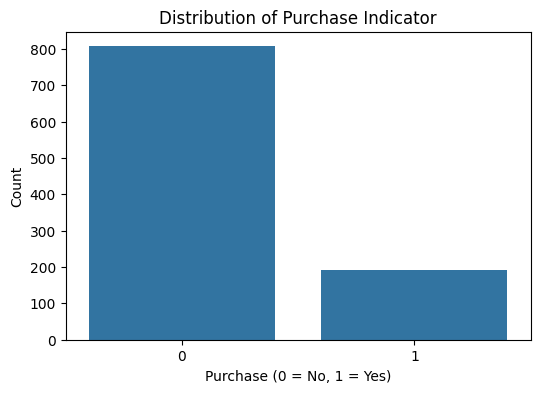

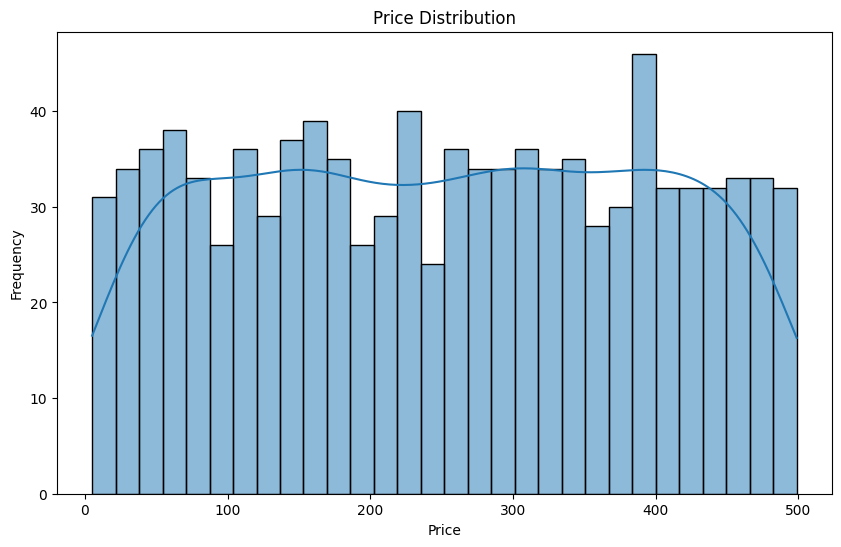

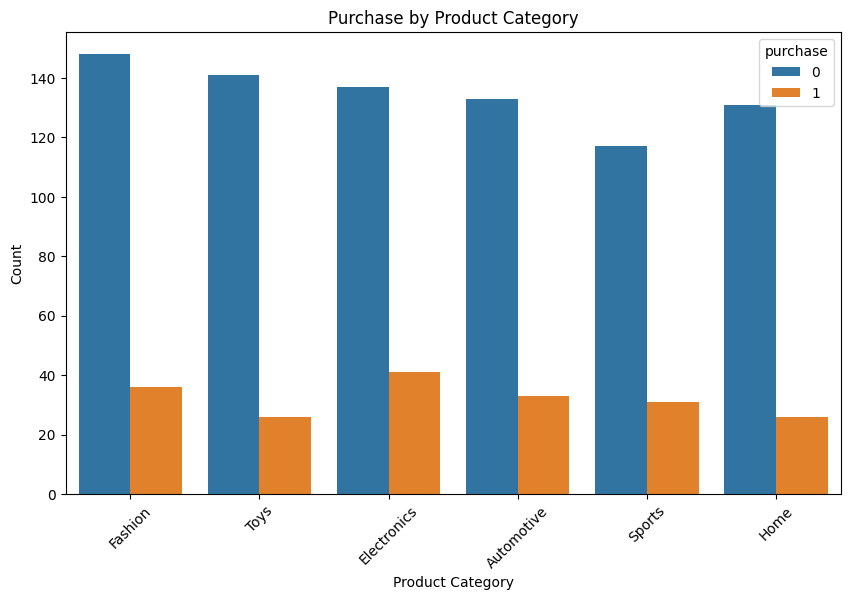

In [2]:
# Summary statistics for numerical features
print("\nSummary statistics:")
print(data.describe())

# Plot the distribution of the target variable 'purchase'
plt.figure(figsize=(6,4))
sns.countplot(x='purchase', data=data)
plt.title("Distribution of Purchase Indicator")
plt.xlabel("Purchase (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

# Visualize the distribution of 'price'
plt.figure(figsize=(10,6))
sns.histplot(data['price'], bins=30, kde=True)
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

# Visualize purchase counts by product category
plt.figure(figsize=(10,6))
sns.countplot(x='product_category', hue='purchase', data=data)
plt.title("Purchase by Product Category")
plt.xlabel("Product Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


In [3]:
# One-hot encode categorical variables: 'action' and 'product_category'
data_encoded = pd.get_dummies(data, columns=['action', 'product_category'], drop_first=True)

# Display the columns after encoding to verify
print("\nColumns after one-hot encoding:")
print(data_encoded.columns)



Columns after one-hot encoding:
Index(['session_id', 'user_id', 'timestamp', 'price', 'purchase', 'hour',
       'day_of_week', 'action_click', 'action_purchase', 'action_view',
       'product_category_Electronics', 'product_category_Fashion',
       'product_category_Home', 'product_category_Sports',
       'product_category_Toys'],
      dtype='object')


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

# Define features (X) and target (y)
# Remove non-informative columns: session_id, user_id, timestamp
X = data_encoded.drop(columns=['purchase', 'session_id', 'user_id', 'timestamp'])
y = data_encoded['purchase']

# Split the dataset into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Model Accuracy:", accuracy)
print("ROC AUC Score:", roc_auc)
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)


Model Accuracy: 0.88
ROC AUC Score: 0.8833705357142858

Confusion Matrix:
[[165   3]
 [ 21  11]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       168
           1       0.79      0.34      0.48        32

    accuracy                           0.88       200
   macro avg       0.84      0.66      0.71       200
weighted avg       0.87      0.88      0.86       200



Best Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Best Cross-Validated ROC AUC: 0.8228269270740128

Best Model Accuracy: 0.86
Best Model ROC AUC Score: 0.8986235119047621


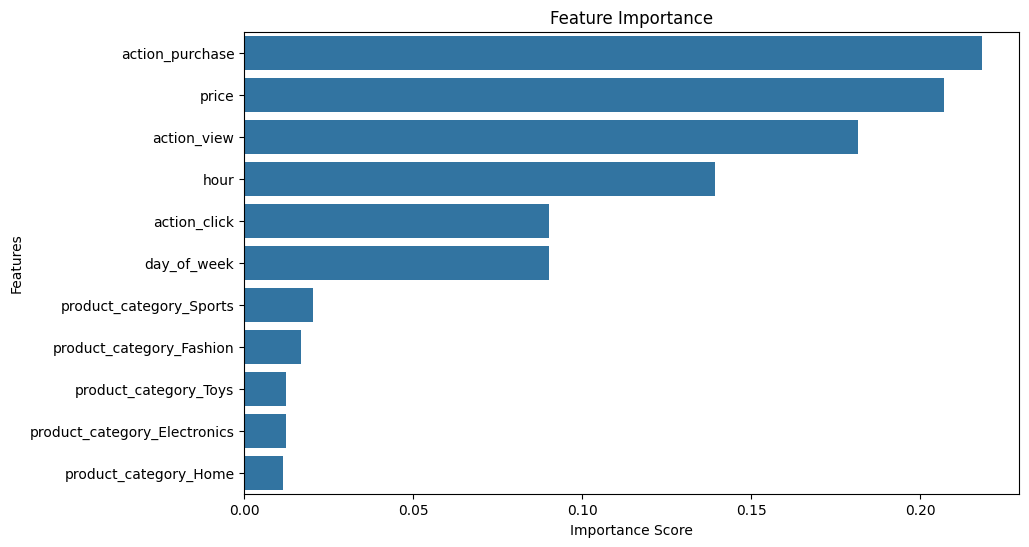

In [5]:
from sklearn.model_selection import GridSearchCV

# Define a grid of hyperparameters for tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

# Set up GridSearchCV to optimize for ROC AUC score
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Output the best parameters and the best cross-validated ROC AUC score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validated ROC AUC:", grid_search.best_score_)

# Use the best estimator to make predictions
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

print("\nBest Model Accuracy:", accuracy_score(y_test, y_pred_best))
print("Best Model ROC AUC Score:", roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1]))

# Plot feature importances from the best model
importances = best_model.feature_importances_
features = X.columns
feature_importance = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feature_importance.values, y=feature_importance.index)
plt.title("Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()


In [6]:
from sklearn.metrics import fbeta_score

# Define a custom evaluation metric: F-beta score with beta=0.5 (emphasizing precision)
def custom_metric(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=0.5)

custom_score = custom_metric(y_test, y_pred_best)
print("Custom Evaluation Metric (F0.5 Score):", custom_score)


Custom Evaluation Metric (F0.5 Score): 0.46875
